Topk, not similarity
Whole gloss, not truncated

In [1]:
import json
from collections import defaultdict
import numpy as np
import pandas as pd
from nltk.corpus import wordnet as wn

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gloss_samples_file = 'data/RuShiftEval/GlossInter/top_all_glosses_pioner_rusemshift.txt'
all_data_samples_file = 'data/RuSemShift/dev.rusemshift_1.data'
target_lemma = 'пионер'

In [3]:
with open(all_data_samples_file) as f:
    data_samples = json.load(f)
                
len(data_samples)

4107

In [4]:
with open(gloss_samples_file) as f:
    gloss_samples = json.load(f)
    
len(gloss_samples)

68

In [5]:
epochs = defaultdict(lambda: defaultdict(int))
topk = 3

data_samples_dict = {sample['id']: sample for sample in data_samples}

for sample in gloss_samples:
    if sample['lemma'] != target_lemma:
        continue
    current_data_sample = data_samples_dict[sample['id']]
    if current_data_sample['grp'] == 'EARLIER':
        for gloss_info in sample['glosses1'][:topk]:
            epochs[gloss_info['synset']]['epoch_1'] += 1
        for gloss_info in sample['glosses2'][:topk]:
            epochs[gloss_info['synset']]['epoch_1'] += 1
    elif current_data_sample['grp'] == 'LATER':
        for gloss_info in sample['glosses1'][:topk]:
            epochs[gloss_info['synset']]['epoch_2'] += 1
        for gloss_info in sample['glosses2'][:topk]:
            epochs[gloss_info['synset']]['epoch_2'] += 1
    elif current_data_sample['grp'] == 'COMPARE':
        for gloss_info in sample['glosses1'][:topk]:
            epochs[gloss_info['synset']]['epoch_1'] += 1
        for gloss_info in sample['glosses2'][:topk]:
            epochs[gloss_info['synset']]['epoch_2'] += 1
    else:
        raise ValueError()
        
synsets = epochs.keys()
epoch_1 = [similarity['epoch_1'] for similarity in epochs.values()]
epoch_2 = [similarity['epoch_2'] for similarity in epochs.values()]

epochs = pd.DataFrame({'synset': synsets, 'similarity_1': epoch_1, 'similarity_2': epoch_2})

epochs.head()

,synset,similarity_1,similarity_2
0,doughboy.n.01,13,17
1,soldier.n.01,3,4
2,anzac.n.01,15,15
3,honorable_discharge.n.01,0,1
4,hero.n.01,0,2


In [6]:
top_synsets_k = 10

sim_max = epochs.apply(lambda row: max(row['similarity_1'], row['similarity_2']), axis=1)
sim_max = sim_max.sort_values(ascending=False)
sim_max = sim_max[:top_synsets_k]

truncated_epochs = epochs.loc[sim_max.index]

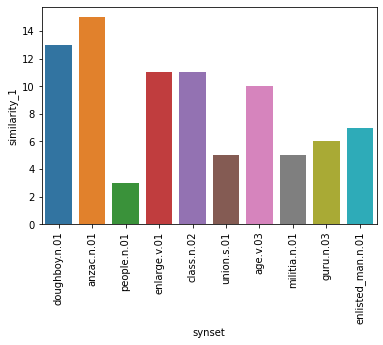

In [7]:
sns.barplot(data=truncated_epochs, x='synset', y='similarity_1')
plt.xticks(rotation=90);

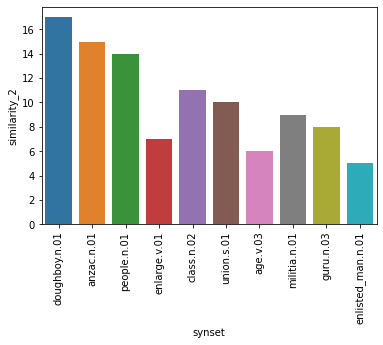

In [8]:
sns.barplot(data=truncated_epochs, x='synset', y='similarity_2')
plt.xticks(rotation=90);

In [9]:
def get_definition(ss, max_chars_num=70):
    ss = wn.synset(ss)
    definition = f'({ss.name()}) {ss.definition()}'
    def_words = definition.split()
    result_definition, current_row = '', ''
    
    for word in def_words:
        possibly_current_row = current_row + ' ' + word
        if len(possibly_current_row) > max_chars_num:
            result_definition += current_row + '\n'
            current_row = word
        else:
            current_row = possibly_current_row
        
    return (result_definition + current_row).strip()

In [10]:
compare_epoch1_df = pd.DataFrame({
    'synset': truncated_epochs['synset'],
    'score': truncated_epochs['similarity_1'] / np.sum(truncated_epochs['similarity_1']),
    'epoch': "1682-1916"
})
compare_epoch2_df = pd.DataFrame({
    'synset': truncated_epochs['synset'],
    'score': truncated_epochs['similarity_2'] / np.sum(truncated_epochs['similarity_2']),
    'epoch': "1918-1990"
})

compare_epochs_df = pd.concat([compare_epoch1_df, compare_epoch2_df])

compare_epochs_df['gloss'] = compare_epochs_df['synset'].apply(lambda ss: get_definition(ss))
compare_epochs_df.head()

,synset,score,epoch,gloss
0,doughboy.n.01,0.151163,1682-1916,(doughboy.n.01) an American infantryman in Wor...
2,anzac.n.01,0.174419,1682-1916,(anzac.n.01) a soldier in the Australian and N...
5,people.n.01,0.034884,1682-1916,(people.n.01) (plural) any group of human bein...
20,enlarge.v.01,0.127907,1682-1916,(enlarge.v.01) make larger
11,class.n.02,0.127907,1682-1916,(class.n.02) a body of students who are taught...


In [11]:
def set_up_fonts():
    sns.set_context("paper", rc={
        "font.size": 15,"axes.titlesize": 15,"axes.labelsize": 17, "legend.fontsize": 17,
        "xtick.labelsize": 14, "ytick.labelsize": 14
    })

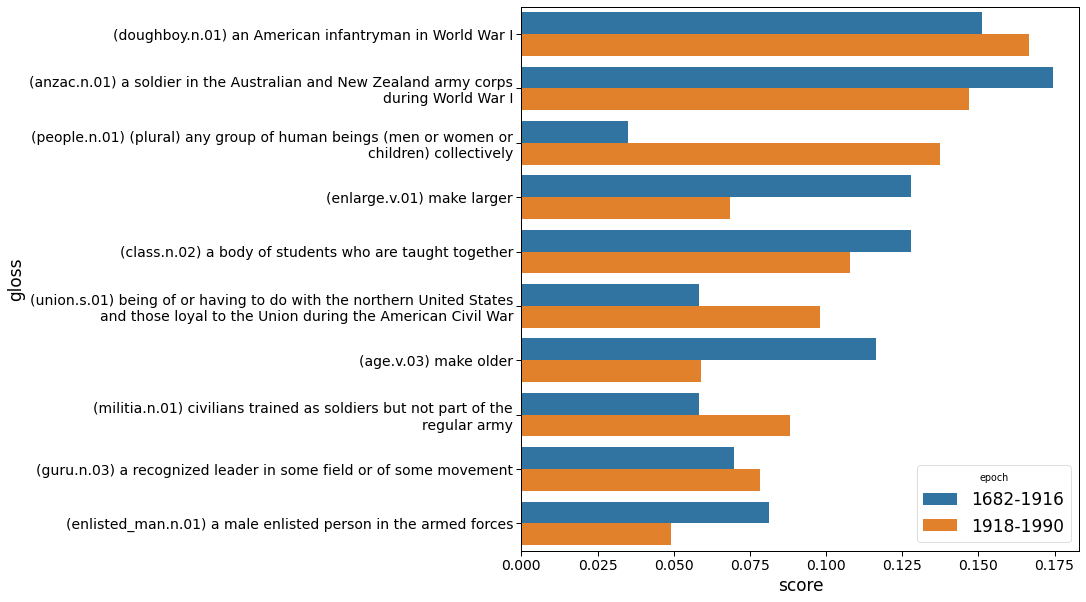

In [12]:
set_up_fonts()
plt.figure(figsize=(10, 10))
sns.barplot(data=compare_epochs_df, y='gloss', x='score', hue='epoch', orient='h')
plt.savefig('data/RuShiftEval/results/image.pdf', bbox_inches='tight')